# Read input data from external Excel sheets...play with economics then
- External excel sheets have some representative input data...the last one you could use for playing
- Don't change the format in the Excel
- ipynb package might not be there in all Anaconda installations
- You might have to change file and directory names
- There are places where one generates the samples and after that saves them to files. You can speed things up later on by reading the samples from the files and skipping the "computation" i.e. resampling. Running everything is often an overkill.
- Functions here are just for plotting. Tweak as needed
- Sampling here loops over discount rates to generate the images...different loops can of course be considered

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from IPython.display import HTML
import matplotlib as mpl
#enable latex editing
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)
import matplotlib.pylab as pylab
params = {'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#might need this to get the movie output working
%matplotlib notebook 

In [9]:
from ipynb.fs.full.NPV_and_LCOE_and_IRR import NPV,NPV2,LCOE,IRR,NPV3  #need: pip install ipynb

In [16]:
filename="./Energy_src_parameters_2019.xlsx"  #Has collection of different parameters from different sources
#some artistic license has been used in adding missing entries

In [17]:
xl = pd.ExcelFile(filename)

In [18]:
names=xl.sheet_names 

In [19]:
print(names)

['Parameters ATB', 'Parameters Fraunhofer 2018', 'Parameters LUT', 'Parameters Narrow', 'Danish data', 'Danish Coal refurbish', 'LUT coal extend', 'EIA', 'EIA existing', 'References']


In [20]:
for i in range(len(names)-1):
    df = pd.read_excel(filename,sheet_name=names[i]) 

In [21]:
#Choose which parameter set you use: several sheets exist in the excel
#df = pd.read_excel(filename,sheet_name=names[0]) #AT
df = pd.read_excel(filename,sheet_name=names[2]) #LUT
#df = pd.read_excel(filename,sheet_name=names[1]) #Fraunhofer...somewhat
#df = pd.read_excel(filename,sheet_name=names[3]) #Playground with small uncertainty
#df = pd.read_excel(filename,sheet_name=names[5]) #Danish coal life extension
#df = pd.read_excel(filename,sheet_name=names[6]) #LUT coal life extension

In [22]:
print(df.shape)
keynames=df.keys()
dimensions=df.shape

(21, 11)


In [23]:
keynames

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend'],
      dtype='object')

In [24]:
#How many techs have been implemented? 1st two columns are parameter names and units
ntech=dimensions[1]-2
#How many parameters each have 
nparams=dimensions[0]
print(nparams)

21


#Read the technology data

In [25]:
techdata=np.zeros([nparams,ntech])
#Parameter names
param_names=df[keynames[0]]
print(param_names)

0                        CAPEX min
1                    CAPEX typical
2                        CAPEX max
3                         lifetime
4            Construction time min
5        Construction time typical
6            Construction time max
7                Discount rate min
8                Discount rate max
9              Capacity factor min
10         Capacity factor typical
11             Capacity factor max
12                       FIXED O&M
13                    Variable O&M
14                       Heat rate
15    Fuel cost min primary energy
16    Fuel cost max primary energy
17           Exchange euro to euro
18               Fuel cost min MWh
19               Fuel cost max MWh
20                   CO2 intensity
Name: Roughly LUT parameters, dtype: object


In [26]:
for i in range(ntech):
    #test=pd.DataFrame(df,columns=[keynames[i+2]])
    test=df[keynames[i+2]]
    techdata[:,i]=test[0:]

1. Read the parameters needed for net present value calculation. Careful with the order!
2. Generate random samples for those that are uncertain
3. Compute the NPV for this particular set of parameters

In [27]:
keynames

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend'],
      dtype='object')

In [51]:
i=0
x=0
co=0
loopsamples=11
co2min=0
co2max=40.0  #euros/ton CO2
#CO2v=np.linspace(co2min,co2max,loopsamples)
CO2v=np.zeros(loopsamples)   #CO2 tax euros/ton CO2...zero for now
dmin=-0.05  #minimum discount
dmax=0.1    #maximum discount
discountv=np.linspace(dmin,dmax,loopsamples)
samples=5000
NPV_techv=np.zeros([samples,loopsamples,ntech])
LCOE_techv=np.zeros([samples,loopsamples,ntech])
It0v=np.zeros([samples,loopsamples,ntech])
rv=np.zeros([samples,loopsamples,ntech])
cfv=np.zeros([samples,loopsamples,ntech])
#40 euros/MWh wholesale average
#filename_add='_low_wholesale_30penetration'   #Add to filenames to clarify
filename_add='_low_wholesale'
wholesalemin=35-12*0   #20  -12 euros/MWh is about the OECD/NEA 2019 estimate for wind price drop at about 30% penetration
wholesalemax=45-12*0   #80
#filename_add='_high_wholesale'   #Add to filenames to clarify
#wholesalemin=70-12*0   #high cost option
#wholesalemax=90-12*0   #
It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])
n=int(techdata[3,i])
construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
r=np.random.uniform(low=techdata[7,i],high=techdata[8,i])
OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
OMfixed=techdata[12,i]
CO2intensity=techdata[20,i]  #tons CO2/MWh
NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[0]/1000,OMfixed,wholesalemin,wholesalemax)/It0
print(NPV_techv[x,co,i])

-0.19621680316129744


In [29]:
wholesale=0.5*(wholesalemin+wholesalemax)
i=0
for i in range(ntech):
    n=int(techdata[3,i])
    OMfixed=techdata[12,i]
    CO2intensity=techdata[20,i]
    It0=techdata[1,i]
    construction_period=techdata[5,i]
    cf=techdata[10,i]
    OMkwh=(techdata[13,i]+0.5*(techdata[18,i]+techdata[19,i]))/1000
    if (i==0):
        internal_rate=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesale-12)
    else:
        internal_rate=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesale)
    print("IRR=",internal_rate*100,i)

IRR= 0.5705234076723075 0
IRR= -1.3627722142706176 1
IRR= -3.79994646179847 2
IRR= -6.542901460621632 3
IRR= 4.458411600775271 4
IRR= -200.0 5
IRR= -200.0 6
IRR= -200.0 7
IRR= -200.0 8


In [56]:
#Loop over all techs and generate all samples for different CO2 prices or discount rates
meanLCOE=np.zeros([loopsamples,ntech])
minLCOE=np.zeros([loopsamples,ntech])
maxLCOE=np.zeros([loopsamples,ntech])
meandiscountedROI=np.zeros([loopsamples,ntech])
mindiscountedROI=np.zeros([loopsamples,ntech])
maxdiscountedROI=np.zeros([loopsamples,ntech])
internal_rate_techv=np.zeros([samples,ntech])
meanIRR=np.zeros(ntech)
stdIRR=np.zeros(ntech)
for i in range(ntech):
    print('Techonology: ',keynames[i+2],i)
    n=int(techdata[3,i])
    OMfixed=techdata[12,i]
    CO2intensity=techdata[20,i]
    for co in range(loopsamples):
        for x in range(samples):
            It0=np.random.uniform(low=techdata[0,i],high=techdata[2,i])            
            construction_period=int(np.random.uniform(low=techdata[4,i],high=techdata[6,i]))
            cf=np.random.uniform(low=techdata[9,i],high=techdata[11,i])
            #r=np.random.uniform(low=techdata[7,i],high=techdata[8,i])
            r=discountv[co]
            rv[x,co,i]=r
            It0v[x,co,i]=It0
            cfv[x,co,i]=cf
            OMkwh=(techdata[13,i]+np.random.uniform(low=techdata[18,i],high=techdata[19,i]))/1000  #Euros/kWh variable O&M
            NPV_techv[x,co,i]=NPV2(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesalemin,wholesalemax)/It0
            LCOE_techv[x,co,i]=LCOE(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed)*1000 #euros/MWh
            if (i==0 or i==1):
                wholesale=0.5*(wholesalemin+wholesalemax)-12*0  #wind at 30% sees 12 euros drop
            else:
                wholesale=0.5*(wholesalemin+wholesalemax)
            if co==0:
                internal_rate_techv[x,i]=IRR(construction_period,n,r,cf,It0,OMkwh+CO2intensity*CO2v[co]/1000,OMfixed,wholesale)
                #if internal_rate_techv[x,i]<-0.99:
                #    internal_rate_techv[x,i]=internal_rate_techv[x-1,i]
        meanIRR[i]=np.mean(internal_rate_techv[:,i])
        stdIRR[i]=np.std(internal_rate_techv[:,i])
        meanLCOE[co,i]=np.mean(LCOE_techv[:,co,i])
        meandiscountedROI[co,i]=np.mean(NPV_techv[:,co,i])
        minLCOE[co,i]=np.min(LCOE_techv[:,co,i])
        maxLCOE[co,i]=np.max(LCOE_techv[:,co,i])
        mindiscountedROI[co,i]=np.min(NPV_techv[:,co,i])
        maxdiscountedROI[co,i]=np.max(NPV_techv[:,co,i])
    print("IRR mean: ",meanIRR[i])
            
            

Techonology:  Wind onshore 0
IRR mean:  -6.03937947349278e-05
Techonology:  Wind offshore 1
IRR mean:  -0.052209460540530446
Techonology:  PV 2
IRR mean:  -0.04121850519210491
Techonology:  PV rooftop 3
IRR mean:  -0.06909863304627738
Techonology:  Nuclear 4
IRR mean:  0.03103932162519896
Techonology:  Natural gas CCGT 5
IRR mean:  -2.0
Techonology:  Natural gas OCGT 6
IRR mean:  -2.0
Techonology:  Coal 7
IRR mean:  -2.0
Techonology:  Coal extend 8
IRR mean:  -2.0


In [57]:
#Native numpy format save for speed and for saving space
#filename_add='_low_wholesale_30penetration'
np.save('./data/samples_NPV'+filename_add+'.npy', NPV_techv)
np.save('./data/samples_LCOE'+filename_add+'.npy', LCOE_techv)
np.save('./data/samples_It0'+filename_add+'.npy', It0v)
np.save('./data/samples_r'+filename_add+'.npy', rv)
np.save('./data/samples_cf'+filename_add+'.npy', cfv)
np.save('./data/samples_IRR'+filename_add+'.npy',internal_rate_techv)
np.save('./data/meanLCOE'+filename_add+'.npy',meanLCOE)
np.save('./data/meanROI'+filename_add+'.npy', meandiscountedROI)
np.save('./data/minLCOE'+filename_add+'.npy',minLCOE)
np.save('./data/minROI'+filename_add+'.npy', mindiscountedROI)
np.save('./data/maxLCOE'+filename_add+'.npy',maxLCOE)
np.save('./data/maxROI'+filename_add+'.npy', maxdiscountedROI)
np.save('./data/meanIRR'+filename_add+'.npy',meanIRR)
np.save('./data/stdIRR'+filename_add+'.npy',stdIRR)

In [66]:
#Read existing samples
#filename_add='_low_wholesale'
NPV_techv_LUT=np.load('./data/samples_NPV'+filename_add+'.npy')
LCOE_techv_LUT=np.load('./data/samples_LCOE'+filename_add+'.npy')
It0v_LUT=np.load('./data/samples_It0'+filename_add+'.npy')
rv_LUT=np.load('./data/samples_r'+filename_add+'.npy')
cfv_LUT=np.load('./data/samples_cf'+filename_add+'.npy')
internal_rate_techv_LUT=np.load('./data/samples_IRR'+filename_add+'.npy')
meanLCOE_LUT=np.load('./data/meanLCOE'+filename_add+'.npy')
meandiscountedROI_LUT=np.load('./data/meanROI'+filename_add+'.npy')
minLCOE_LUT=np.load('./data/minLCOE'+filename_add+'.npy')
mindiscountedROI_LUT=np.load('./data/minROI'+filename_add+'.npy')
maxLCOE_LUT=np.load('./data/maxLCOE'+filename_add+'.npy')
maxdiscountedROI_LUT=np.load('./data/maxROI'+filename_add+'.npy')
meanIRR_LUT=np.load('./data/meanIRR'+filename_add+'.npy')
stdIRR_LUT=np.load('./data/stdIRR'+filename_add+'.npy')

In [35]:
keynames

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend'],
      dtype='object')

In [36]:
meanIRR

array([ 0.03764185, -0.02069361, -0.04131556, -0.06925404,  0.03098846,
       -2.        , -2.        , -2.        , -2.        ])

In [42]:
stdIRR

array([0.01283573, 0.01062781, 0.00734709, 0.01083055, 0.00651141,
       0.        , 0.        , 0.        , 0.        ])

9 Wind onshore -0.00603937947349278 1.1032699394950016
9 Wind offshore -5.220946054053044 0.9432465109942796
9 PV -4.121850519210491 0.7374583835635047
9 Nuclear 3.103932162519896 0.6609004900264628
[-0.00603938 -5.22094605 -4.12185052  3.10393216]
[1.10326994 0.94324651 0.73745838 0.66090049]


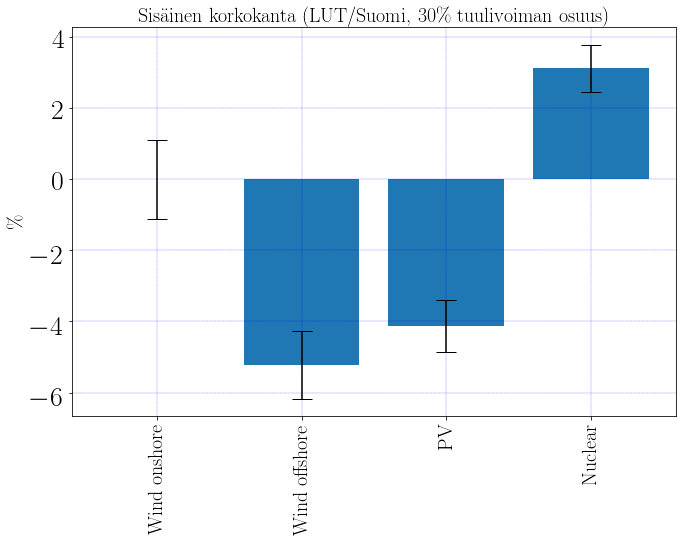

In [59]:
exclude=5   #remove rooftop and fossil fuels
exclude=5   #remove rooftop, coal extend and OCGT
x2 = np.arange(ntech-exclude)
bardata=np.zeros(ntech-exclude)
errordata=np.zeros(ntech-exclude)
keynames2=[]
pos=0
for j in range(ntech-4):
    #if (keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT" and keynames[j+2]!="Natural gas CCGT" and keynames[j+2]!="Coal"):        
    if (keynames[j+2]!="Natural gas CCGT" and keynames[j+2]!="Coal" and keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT"  and keynames[j+2]!="Coal existing"):
    #if (keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT"  and keynames[j+2]!="Coal existing"):
        print(ntech,keynames[j+2],meanIRR[j]*100,stdIRR[j]*100)        
        bardata[pos]=meanIRR[j]*100
        errordata[pos]=stdIRR[j]*100
        #keynames2[pos]=keynames[j+2]
        keynames2.append(keynames[j+2])
        pos=pos+1

print(bardata)
print(errordata)
x = np.arange(ntech)
fig = plt.figure(figsize=(10,8))
#fig, ax = plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('ytick',labelsize=28)
plt.rc('xtick',labelsize=28)
#ax.yaxis.set_major_formatter(formatter)
#plt.bar(x, meanIRR*100)
plt.bar(x2, bardata,yerr=errordata,align='center',capsize=10)
#plt.xticks(x, keynames[2:], rotation='vertical', fontsize=20)
plt.xticks(x2, keynames2, rotation='vertical', fontsize=20)
plt.title("Sisäinen korkokanta (LUT/Suomi, 30\% tuulivoiman osuus)", fontsize=20)
#plt.title("Sisäinen korkokanta (ATB/USA)", fontsize=20)
plt.ylabel("\%", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.tight_layout()
filenamepng= "./IRR_LUT_Suomi_30percent.png"
#filenamepng= "./IRR_ATB_USA.png"
#filenamepdf= "./sample" + str(i+1)+ ".pdf"    
plt.savefig(filenamepng,dpi=300)
plt.show()

In [223]:
bardata.shape
ntech=8

Wind onshore
Wind offshore
PV
Nuclear
Natural gas CCGT
Coal
Wind onshore
Wind offshore
PV
Nuclear
Natural gas CCGT
Coal
[ 3.55718036 -4.12139822  3.01680065  3.60910291 12.89142113  1.13955617]
[2.65591687 1.535406   3.12245408 0.89595627 4.37382951 0.90822276]


<IPython.core.display.Javascript object>


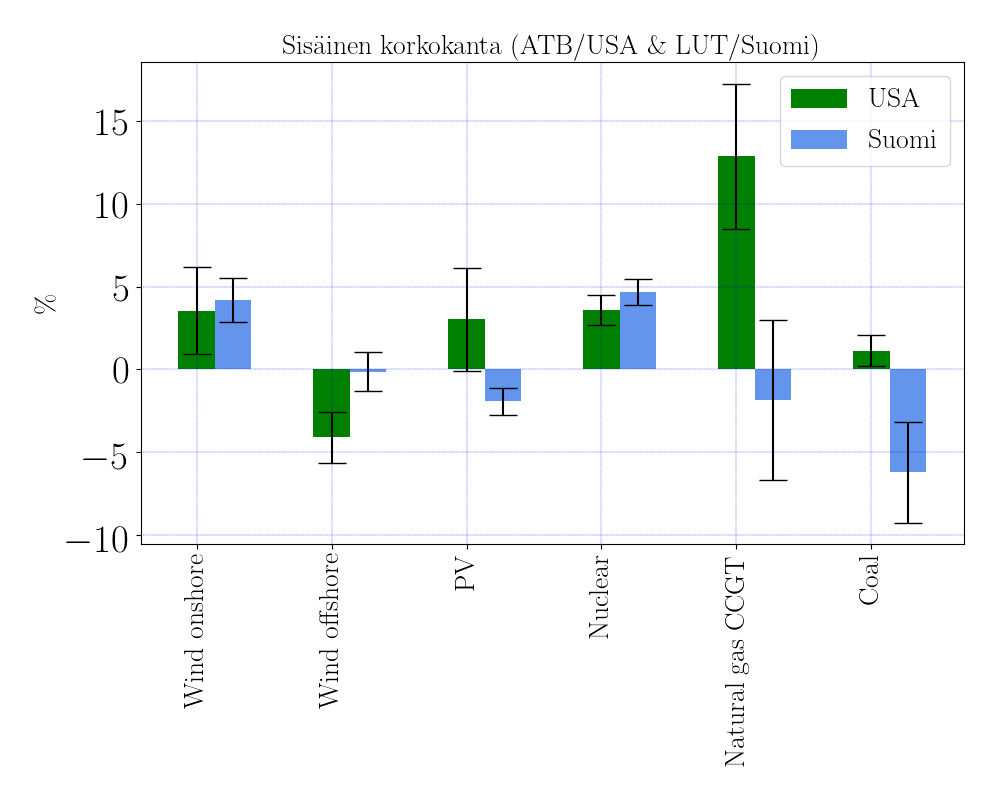

In [233]:
#Just different plotting commands...no real computations here anymore
exclude=4   #remove rooftop and fossil fuels
exclude=2   #remove rooftop, coal extend and OCGT
exclude2=5 
exclude2=3 
x2 = np.arange(ntech-exclude)
bardata=np.zeros(ntech-exclude)
errordata=np.zeros(ntech-exclude)
bardata2=np.zeros(ntech-exclude)
errordata2=np.zeros(ntech-exclude)
keynames2=[]
pos=0
for j in range(ntech):
    #if (keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT" and keynames[j+2]!="Natural gas CCGT" and keynames[j+2]!="Coal"):        
    if (keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT"):
        print(keynames[j+2])
        bardata[pos]=meanIRR[j]*100
        errordata[pos]=stdIRR[j]*100
        #keynames2[pos]=keynames[j+2]
        keynames2.append(keynames[j+2])
        pos=pos+1

keynames3=[]
pos=0
for j in range(ntech):
    #if (keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT" and keynames[j+2]!="Natural gas CCGT" and keynames[j+2]!="Coal"):        
    if (keynames[j+2]!="PV rooftop" and keynames[j+2]!="Coal extend" and keynames[j+2]!="Natural gas OCGT"):
        print(keynames[j+2])
        bardata2[pos]=meanIRR_LUT[j]*100
        errordata2[pos]=stdIRR_LUT[j]*100
        #keynames2[pos]=keynames[j+2]
        keynames3.append(keynames[j+2])
        pos=pos+1
print(bardata)
print(errordata)
x = np.arange(ntech)
width = 0.27 

fig = plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('ytick',labelsize=28)
plt.rc('xtick',labelsize=28)
bar1=plt.bar(x2, bardata,width,yerr=errordata,align='center',capsize=10,color='green',label='USA')
plt.xticks(x2, keynames2, rotation='vertical', fontsize=20)
colorv=['cornflowerblue','royalblue','darkorange','orange','green','chocolate','saddlebrown','darkgray','dimgray']
bar2 = plt.bar(x2+width, bardata2, width,yerr=errordata2,align='center',capsize=10,color='cornflowerblue',label='Suomi')
#plt.title("Cost reduction when discounting with 10\% removed", fontsize=16)
plt.title("Sisäinen korkokanta (ATB/USA \& LUT/Suomi)", fontsize=20)
plt.ylabel("\%", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.legend(loc='upper right', prop={'size': 20})
plt.tight_layout()
#filenamepng= "./IRR_ATB_LUT_only_Low_C.png"
filenamepng= "./IRR_ATB_LUT.png"
#filenamepdf= "./sample" + str(i+1)+ ".pdf"    
plt.savefig(filenamepng,dpi=300)
plt.show()

In [95]:
print(keynames)

Index(['Roughly LUT parameters', 'Units', 'Wind onshore', 'Wind offshore',
       'PV', 'PV rooftop', 'Nuclear', 'Natural gas CCGT', 'Natural gas OCGT',
       'Coal', 'Coal extend'],
      dtype='object')


In [ ]:
#bar plot of the difference betweeb 0% and 10% discount: (1-cost0/cost10)*100 cost reduction in % from 10%

In [22]:
change_in_cost=np.zeros(ntech)
for i in range(ntech):
    change_in_cost[i]=100*(1-meanLCOE[0,i]/meanLCOE[loopsamples-1,i])    
print(change_in_cost)

[74.15484629 78.82301702 73.91639775 77.04171237 82.33269991 24.0850179
 13.30023845 35.91740563  6.80445287  2.14435334]


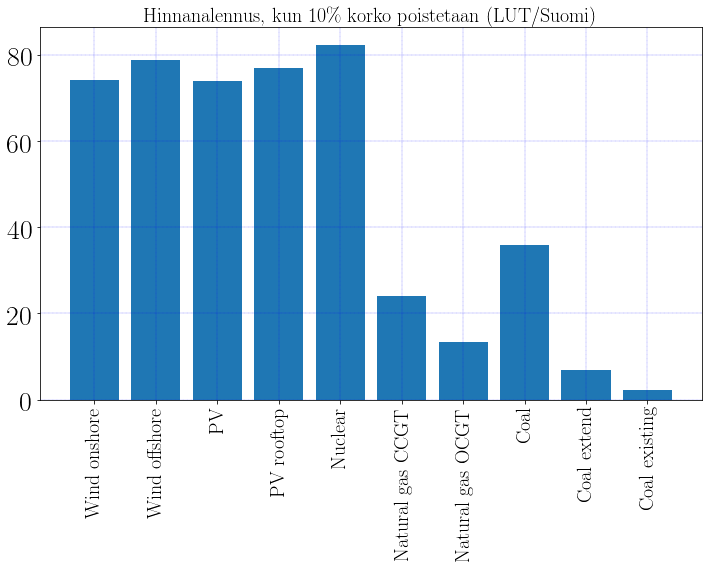

In [23]:
x = np.arange(ntech)
fig = plt.figure(figsize=(10,8))
#fig, ax = plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('ytick',labelsize=28)
plt.rc('xtick',labelsize=28)
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, change_in_cost)
plt.xticks(x, keynames[2:], rotation='vertical', fontsize=20)
#plt.title("Cost reduction when discounting with 10\% removed", fontsize=16)
plt.title("Hinnanalennus, kun 10\% korko poistetaan (LUT/Suomi)", fontsize=20)
plt.grid(color='b', linestyle='--', linewidth=0.25)
plt.tight_layout()
filenamepng= "./costreduction_no_discount_Suomi.png"
#filenamepdf= "./sample" + str(i+1)+ ".pdf"    
plt.savefig(filenamepng,dpi=300)
plt.show()

In [ ]:
import matplotlib.animation as mplanimation

In [51]:

    
#Function that generates the plots comparing two different technologies for net present value
def animate_NPV_compare_two(i):
    ti1=0
    ti2=4
    ti=ti1
    plt.clf()
    mpl.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(10,6))
    minval1=NPV_techv[:,i,ti].min()
    maxval1=NPV_techv[:,i,ti].max()
    minval2=NPV_techv[:,i,ti2].min()
    maxval2=NPV_techv[:,i,ti2].max()
    minval=min(minval1,minval2)
    maxval=max(maxval1,maxval2)
    bins_fixed = np.linspace(minval,maxval, 250)
    colorv=['cornflowerblue','royalblue','darkorange','orange','green','chocolate','saddlebrown','dimgray']
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    CO2taxv=np.zeros(1)
    colorh=colorv[ti]
    colorh2=colorv[ti2]
    yn, xp, _ =plt.hist(NPV_techv[:,i,ti], bins_fixed,alpha=0.5,density=True,label=keynames[ti+2],color=colorh)
    yn2, xp, _ =plt.hist(NPV_techv[:,i,ti2], bins_fixed,alpha=0.4,density=True,label=keynames[ti2+2],color=colorh2)
    ymax1=yn.max()
    ymax2=yn2.max()
    ymax=max(ymax1,ymax2)
    xmin1=np.min(NPV_techv[:,:,ti1])
    xmin2=np.min(NPV_techv[:,:,ti2])
    xmax1=np.max(NPV_techv[:,:,ti1])
    xmax2=np.max(NPV_techv[:,:,ti2])
    xmin=min(xmin1,xmin2)
    xmax=max(xmax1,xmax2)
    xv=np.ones(2)*np.mean(NPV_techv[:,i,ti])
    yv=np.zeros(2)
    yv[1]=ymax*1.1
    plt.plot(xv,yv,color=colorh, linewidth=4)
    xv2=np.ones(2)*np.mean(NPV_techv[:,i,ti2])
    plt.plot(xv2,yv,color=colorh2, linewidth=4)
    plt.legend(loc='upper right', prop={'size': 20})
    CO2taxv=np.zeros(loopsamples)
    plt.title("NPV: discount rate="+str(round(rminv[i]*100,2))+" $\%$",fontsize=32)
    #plt.title("LCOE: CO$_{2}$="+str(round(CO2taxv[i],1))+" €/MWh")
    plt.xlabel("NPV/Investment")
    plt.xlim(xmin,xmax)
    plt.ylim((0,yv[1]))
    plt.yticks([])
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.tight_layout()
    filenamepng= "./compare_NPV"+str(ti)+"_"+str(ti2)+"_" + str(i+1)+ ".png"
    #filenamepdf= "./sample" + str(i+1)+ ".pdf"    
    plt.savefig(filenamepng,dpi=300)
    #plt.savefig(filenamepdf)
    im=plt.show()
    return(plt)
    #ims.append([im])

In [42]:
#Function that generates the plots comparing two different technologies for LCOE
def animate_IRR_compare_two(i):
    ti1=0
    ti2=0
    ti=ti1
    plt.clf()
    mpl.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(10,6))
    minval1=100*internal_rate_techv[:,ti].min()-0.0
    maxval1=100*internal_rate_techv[:,ti].max()+2
    minval2=100*internal_rate_techv_LUT[:,ti2].min()-0.0
    maxval2=100*internal_rate_techv_LUT[:,ti2].max()+2
    minval=min(minval1,minval2)
    maxval=max(maxval1,maxval2)
    minval=-10
    maxval=20
    bins_fixed = np.linspace(minval,maxval, 250)
    colorv=['cornflowerblue','green','chocolate','saddlebrown','dimgray']
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    colorh=colorv[0]
    colorh2=colorv[1]
    yn, xp, _ =plt.hist(100*internal_rate_techv[:,ti], bins_fixed,alpha=0.7,density=True,label='USA',color=colorh)
    yn2, xp, _ =plt.hist(100*internal_rate_techv_LUT[:,ti2], bins_fixed,alpha=0.6,density=True,label='Suomi',color=colorh2)
    plt.legend(loc='upper right', prop={'size': 20})
    plt.title("Sisäinen korkokanta: tuulivoima USA vs. Suomi",fontsize=32)
    #plt.title("LCOE: CO$_{2}$="+str(round(CO2taxv[i],1))+" €/MWh")
    plt.xlabel("IRR [\%]")
    xmin=-5
    xmax=15
    plt.xlim(xmin,xmax)
    plt.ylim((0,0.25))
    plt.yticks([])
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.tight_layout()
    filenamepng= "./IRR_compare_distributions_wind.png"
    #filenamepdf= "./sample" + str(i+1)+ ".pdf"    
    plt.savefig(filenamepng,dpi=300)
    #plt.savefig(filenamepdf)
    im=plt.show()
    return(plt)
    #ims.append([im])

In [68]:
#Function that generates the plots comparing two different technologies for LCOE
def animate_IRR_compare_two_techs(i):
    ti1=0
    ti2=4
    #ti1=4
    #ti2=5
    ti=ti1
    plt.clf()
    mpl.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(10,6))
    minval1=100*internal_rate_techv_LUT[:,ti].min()-0.0
    maxval1=100*internal_rate_techv_LUT[:,ti].max()+2
    minval2=100*internal_rate_techv_LUT[:,ti2].min()-0.0
    maxval2=100*internal_rate_techv_LUT[:,ti2].max()+2
    minval=min(minval1,minval2)
    maxval=max(maxval1,maxval2)
    minval=0
    maxval=11
    #maxval=25    
    bins_fixed = np.linspace(minval,maxval, 250)
    colorv=['cornflowerblue','green','chocolate','saddlebrown','dimgray']
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    colorh=colorv[0]
    colorh2=colorv[1]
    yn, xp, _ =plt.hist(100*internal_rate_techv_LUT[:,ti], bins_fixed,alpha=0.7,density=True,label='Wind (low penetration)',color=colorh)
    yn2, xp, _ =plt.hist(100*internal_rate_techv_LUT[:,ti2], bins_fixed,alpha=0.6,density=True,label='Nuclear',color=colorh2)
    plt.legend(loc='upper right', prop={'size': 20})
    plt.title("Sisäinen korkokanta: tuulivoima \& ydinvoima (Suomi)",fontsize=24)
    #yn, xp, _ =plt.hist(100*internal_rate_techv_LUT[:,ti], bins_fixed,alpha=0.7,density=True,label='Nuclear',color=colorh)
    #yn2, xp, _ =plt.hist(100*internal_rate_techv_LUT[:,ti2], bins_fixed,alpha=0.6,density=True,label='Natural gas CCGT',color=colorh2)
    #plt.legend(loc='upper right', prop={'size': 20})
    #plt.title("Sisäinen korkokanta: ydinvoima \& maakaasu (Suomi, 80€/MWh sähkö, 20€/tCO2)",fontsize=16)
    #plt.title("LCOE: CO$_{2}$="+str(round(CO2taxv[i],1))+" €/MWh")
    plt.xlabel("IRR [\%]")
    xmin=0
    xmax=10
    #xmax=24
    plt.xlim(xmin,xmax)
    plt.ylim((0,0.70))
    plt.yticks([])
    plt.grid(color='b', linestyle='--', linewidth=0.25)
    plt.tight_layout()
    filenamepng= "./IRR_distributions.png"
    #filenamepdf= "./sample" + str(i+1)+ ".pdf"    
    plt.savefig(filenamepng,dpi=300)
    #plt.savefig(filenamepdf)
    im=plt.show()
    return(plt)
    #ims.append([im])

<Figure size 432x288 with 0 Axes>

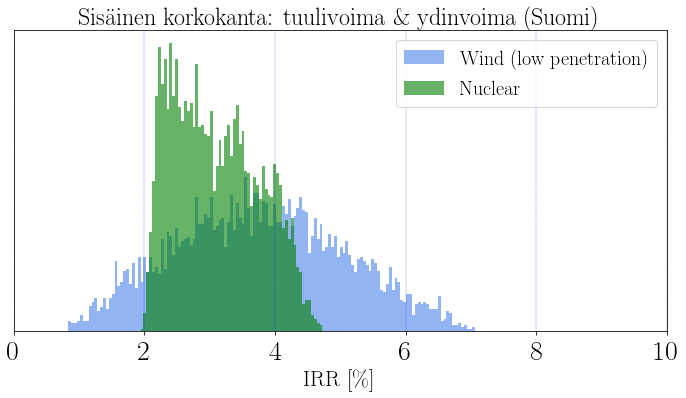

<module 'matplotlib.pyplot' from '/u/33/martikj2/unix/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [69]:
animate_IRR_compare_two_techs(0)